In [2]:
import os, sys
import glob
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import datetime as dt

#matplotlib.rc('text', usetex=True)
from scipy import ndimage

import seaborn as sns

sns.set(style="white")
sns.set_context("paper", font_scale=2.5)
sys.path.append('../')

from data import geonexl1b
import models
from models import SplitAutoEncoder, SplitGenVAE

import utils
from inference import domain_to_domain, load_model


import torchvision

## Set Days and Tiles

In [3]:
year = 2018
month = 10
day = 10
hour = 6
date = dt.datetime(year, month, day)

vrange = list(range(13,16))
hrange = list(range(53,56))

vrange = list(range(3,6))
hrange = list(range(11,14))


dayofyear = date.timetuple().tm_yday

In [4]:
def save_image(img, fname, cmap='jet', vmin=None, vmax=None):
    h, w = 5, 5
    fig = plt.figure(frameon=False)
    fig.set_size_inches(w, h)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    ax.imshow(img, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    fig.savefig(fname, dpi=300)
    plt.close()

In [5]:
sensor = 'H8'
geodata = geonexl1b.GeoNEXL1b('/nex/projects/goesscratch/weile/AHI05_java/output/HDF4', sensor)
datafiles = geodata.files(year=year, dayofyear=dayofyear)
datafiles = datafiles[datafiles['hour'] == hour]
datafiles = datafiles[datafiles['minute'] == 0]
files = datafiles.pivot('v', 'h', 'file')

goespaired = geonexl1b.L1bPaired('../data/Test/GOES17/GEONEX-L1B/', 
                                 '../data/Test/HIMAWARI8/GEONEX-L1B/',
                                 'G16', 'G17')
files = goespaired.files(cachedir='tmp').reset_index()
h8files = files.pivot('v1', 'h1', 'file2')
#h8files = h8files[hrange].loc[vrange]
#files = files.head(50)
h8files

g17files = files.pivot('v1', 'h1', 'file1')
#g17files = g17files[hrange].loc[vrange]
#files = files.head(50)
g17files


KeyError: 'file'

In [62]:
files = h8files

hsize = files.shape[1]
vsize = files.shape[0]

exp_config_file = '/nobackupp10/tvandal/nex-ai-geo-translation/configs/Base-G16G17H8.yaml'
model, params = load_model(exp_config_file)
params

size = 600
data = np.empty((vsize*size, hsize*size, 16))
prediction = np.empty_like(data)
latent_space = np.empty((vsize*size, hsize*size, 64))
for ih in range(hsize):
    for iv in range(vsize):
        f = files.values[iv, ih]
        arr = geonexl1b.L1bFile(f, resolution_km=1.).load()
        data[iv*size:(iv+1)*size, ih*size:(ih+1)*size] = arr
        g16_synth, z = domain_to_domain(model, arr, 'H8', 'G16', latent=True)
        prediction[iv*size:(iv+1)*size, ih*size:(ih+1)*size] = g16_synth
        latent_space[iv*size:(iv+1)*size, ih*size:(ih+1)*size] =  np.transpose(z, (1,2,0))

Loaded model from step: 199001


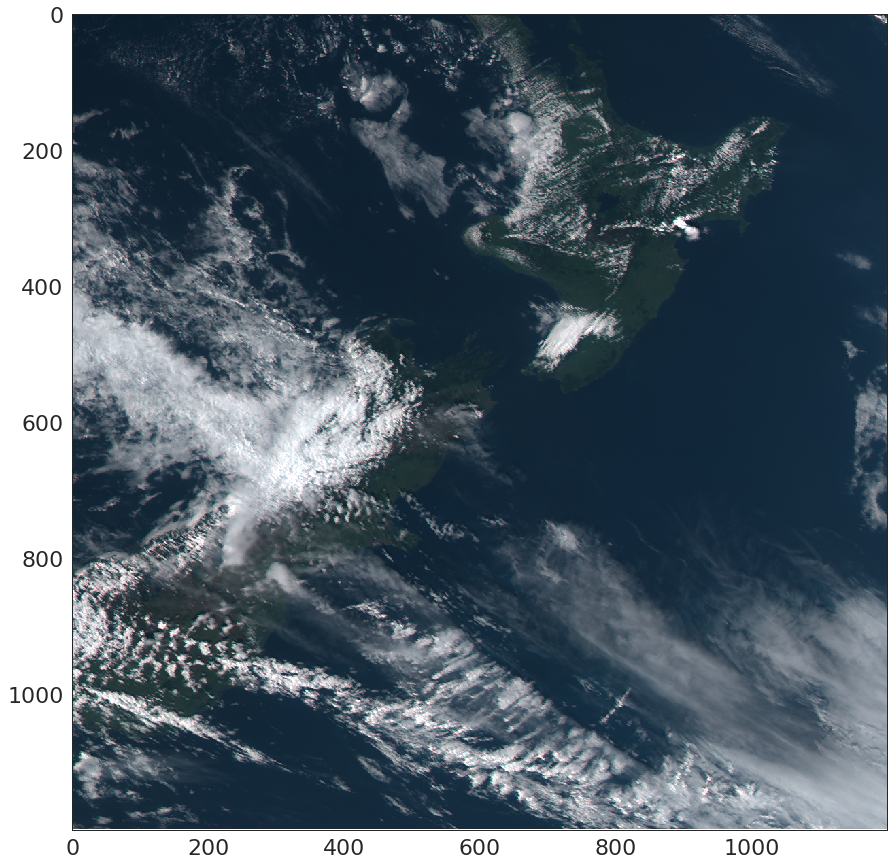

(-0.5, 1199.5, 1199.5, -0.5)

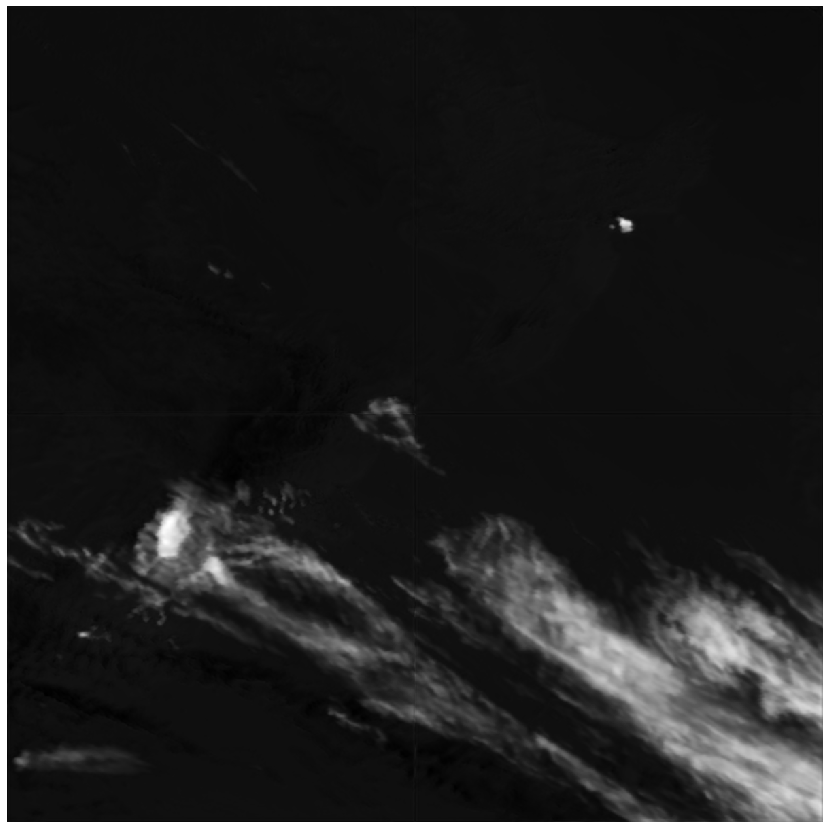

In [63]:
def green_correction(img, F):
    img[:,:,1] = (1-F) * img[:,:,1] + F * img[:,:,3]
    return img

arr = green_correction(data, 0.07)

fig, axs = plt.subplots(1,1,figsize=(15,15))
axs.imshow(arr[:,:,[2,1,0]])
plt.show()

save_image(arr[:,:,[2,1,0]],'figures/rgb_observed_h8.png')



cirrus_synth = prediction[:,:,3]
save_image(cirrus_synth,'figures/cirrus_synthetic_h8.png', cmap='gray')

fig, axs = plt.subplots(1,1,figsize=(15,15))
axs.imshow(cirrus_synth, cmap='gray')
axs.axis('off')

In [66]:
print(latent_space.shape)
idxs = np.argsort(np.mean(latent_space, axis=(0,1)))[::-1]

(1200, 1200, 64)


(64, 600, 600) torch.Size([9618, 9618, 3])
torch.Size([9618, 3, 9618])


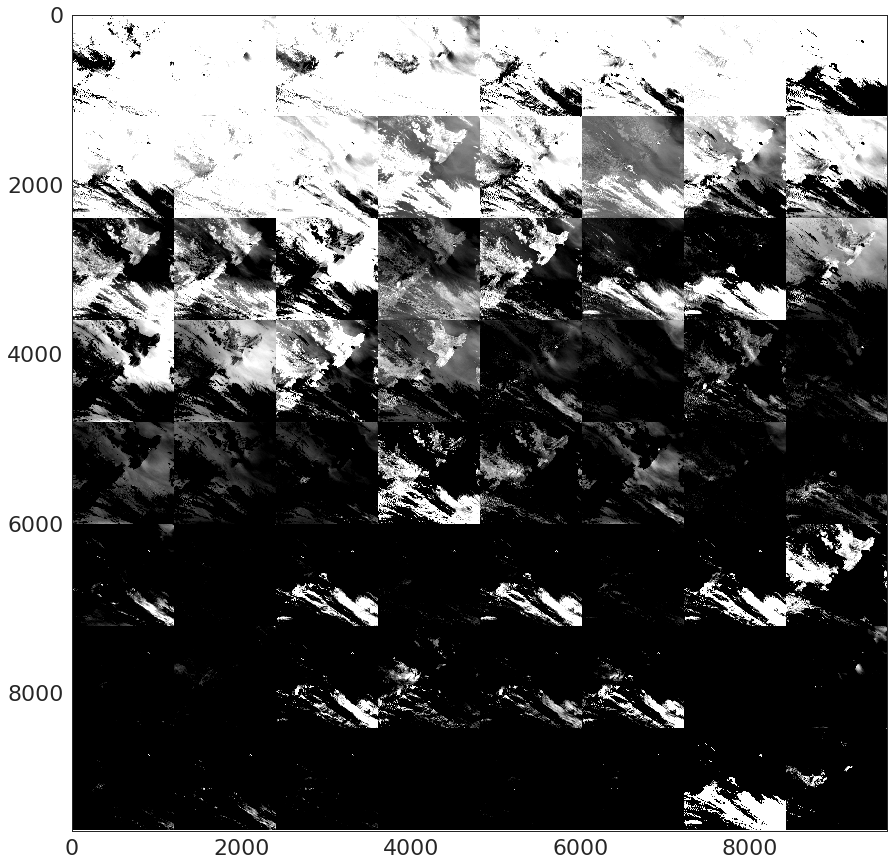

In [67]:

temp = np.transpose(latent_space, (2,0,1))
grid_z = torchvision.utils.make_grid(torch.tensor(temp[idxs,np.newaxis]), 8)
grid_z = np.transpose(grid_z, (1,2,0))
print(z.shape, grid_z.shape)
fig, axs = plt.subplots(1,1,figsize=(15,15))
print(np.transpose(grid_z, (1,2,0)).shape)
axs.imshow(grid_z)#, vmin=-1.5, vmax=1.5)

save_image(grid_z,'figures/latent_features_h8.png', cmap='gray')



In [ ]:
plt.imshow(z[-3], cmap='gray')